# Sensitivity Analyses of the MRM

In this notebook we test how sensitive the multiple-reactivation model is 
to parameter and model misspecification. In particular, we look at

- the effect of a misspecified $v_0$ parameter
- the effect of intra-host variation of the growth rate $G$

We will simulate data sets, and estimate parameters with a simplified 
version of the Stan model.

1. First, we test the simulator and plot simulated data sets
2. Then we compile the simplified Stan model
3. We fit the Stan model to the simulated data set
4. Then we simulate a large number of data sets with intra-host variation in $G$
5. And we fit models to data sets with misspecified $v_0$.
6. Finally we make a figure showing the bias as a result of model misspecification

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib
import scipy.stats as sts
import scipy
import pystan
import os
from multiprocessing import Pool, cpu_count

import sys
sys.path.append("..")
from mrmpytools.pystantools import cachedStanModel, calcWAIC, approximate_mode
from mrmpytools import definitions as defn
from mrmpytools import utilities as util
from mrmpytools import plots
from mrmpytools import simulations as sims
from mrmpytools import stats

import importlib
for mod in [defn, util, plots, sims, stats]:
    importlib.reload(mod)

In [2]:
plt.rcParams.update({'font.size': 18})

## 1. Simulate VL data

We use a simulator defined in `mrmpytools.simulations`. This produces VL trajectories from the generalized MRM, and adds VL measurement error.

We make a figure and put the data in a dictionary that will be used later

Text(0.5, 0.05, 'time post treatment interruption (days)')

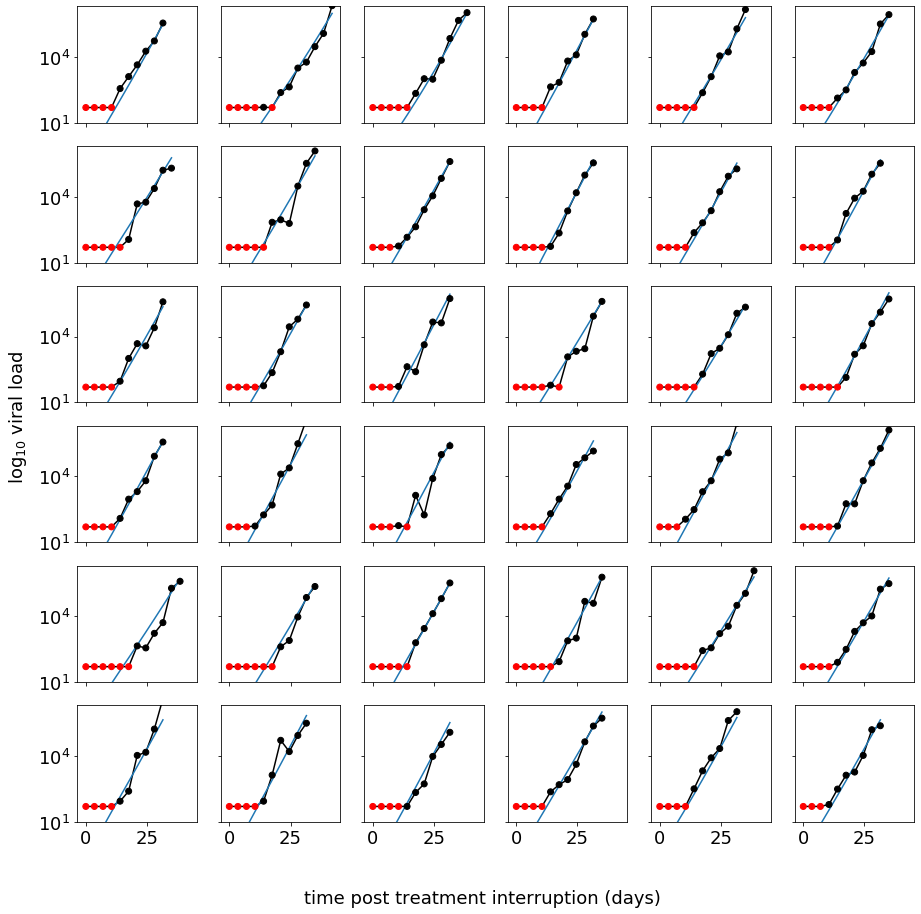

In [3]:
ell = 50
v0 = 0.1
g = 0.5
lam0 = 1.0
sigma = 0.05
ggen = stats.gen_ggen_trunc_propto(sigma, g)


num_sims = 36
num_rows = 6
num_cols = num_sims // num_rows
fig, axs = plt.subplots(num_cols, num_rows, figsize=(15,15), sharex=True, sharey=True)

sim_data_dict = {}

for i in range(num_sims):
    row = i % num_rows
    col = i // num_rows
    ax = axs[row, col]
    ts, Vobs, Vtots, Ts, gs = sims.simVGtimeseries(ell, ggen, v0, lam0, 3.5, 1e6, 0.3)
    VLs = [x[0] for x in Vobs]
    CCs = [x[1] for x in Vobs]
    ax.plot(ts, VLs, color='k', zorder=1)
    ax.scatter(ts, VLs, color=['k' if c == 0 else 'red' for c in CCs], zorder=2)
    ax.set_yscale('log')
    ax.plot(ts, Vtots, color='tab:blue', zorder=1)
    ## put data in sim_data_dict
    sim_data_dict[i] = list(zip(ts, VLs, CCs))
    
ax.set_ylim(1e1, 2e6)

fig.text(0.06, 0.5, "$\\log_{10}$ viral load", va='center', rotation=90)
fig.text(0.5, 0.05, "time post treatment interruption (days)", ha='center')

## 2. Compile the Stan model

We use a simplified Stan model that assumes exponential growth and has no random effects. The model can be found in the `stan-models` directory:

> `expon-rebound-model-multiple-reactiv-II-Gsp.stan`

In [4]:
## make a cache directory for the stan models to avoir re-compiling
cache_dir = os.path.join("..", "stan-models", "cache")
try:
    os.mkdir(cache_dir)
    print("created stan cache directory")
except FileExistsError:
    pass

stan_file = "expon-rebound-model-multiple-reactiv-II-Gsp.stan"
stan_dir = os.path.join("..", "stan-models")

with open(os.path.join(stan_dir, stan_file), 'r') as f:
    sm_Gsp_II = cachedStanModel(model_code=f.read(), model_name="GspII", work_dir=cache_dir)

Using cached StanModel


## 3. Fit Stan model to simulated data.

Next, we fit the Stan model to the data simulated above. This involves...

1. Re-formatting the data in a structure that Stan can understand
2. Running the Stan model
3. Plotting a figure of the fit

In [5]:
## Format data

IDs = sorted(list(sim_data_dict.keys()))

NumTimePts = [len(sim_data_dict[ID]) for ID in IDs]
zpadding = [[0 for _ in range(max(NumTimePts) - n)] for n in NumTimePts]
cpadding = [[defn.missing_code for _ in range(max(NumTimePts) - n)] for n in NumTimePts]

TimePts = [[x[0] for x in sim_data_dict[ID]] + pad for ID, pad in zip(IDs, zpadding)]
VirusLoad = [[x[1] for x in sim_data_dict[ID]] + pad for ID, pad in zip(IDs, zpadding)]
CensorCode = [[x[2] for x in sim_data_dict[ID]] + pad for ID, pad in zip(IDs, cpadding)]

DetectionLimit = ell
MaxLogVZero = np.log(DetectionLimit)

PriorMeanSigma = 0.0 
PriorSdSigma = 0.5

NumSimTimePts = 100

data_dict = {
    "NumSubjects" : len(IDs),
    "NumTimePts" : NumTimePts,
    "TimePts" : TimePts,
    "NumSimTimePts" : NumSimTimePts,
    "VirusLoad" : VirusLoad,
    "CensorCode" : CensorCode,
    "DetectionLimit" : DetectionLimit,
    "PriorMeanLogR" : 0.0,
    "PriorSdLogR" : 1.0,
    "MaxR" : 4.0,
    "PriorMeanSigma" : PriorMeanSigma,
    "PriorSdSigma" : PriorSdSigma,
    ## hyper parameters for the reactivation model
    "PriorMeanLogLambda" : 0.0,
    "PriorSdLogLambda" : 3.0,
    "LogVZero" : np.log(v0),
}

def gen_init_dict():
    return {
        "logr" : np.log(g),
        "sigma" : PriorMeanSigma + PriorSdSigma,
        ## initial values for the reavtivation model
        "loglambda" : 0.0,
        "relativeReboundTime" : [8.0 for _ in IDs],
        "fstReactivTime" : [1.0 for _ in IDs],
    }

In [6]:
## Run the Stan model

control_dict = {
    "adapt_delta" : 0.99,
    "max_treedepth" : 20
}

kwargs = {
    "data" : data_dict,
    "init" : gen_init_dict,
    "iter" : 1000,
    "chains" : 4,
    "thin" : 1,
    "control" : control_dict,
    "refresh" : 10
}

sam = sm_Gsp_II.sampling(**kwargs)
chain = sam.extract(permuted=True)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Text(0.5, 0.05, 'time post treatment interruption (days)')

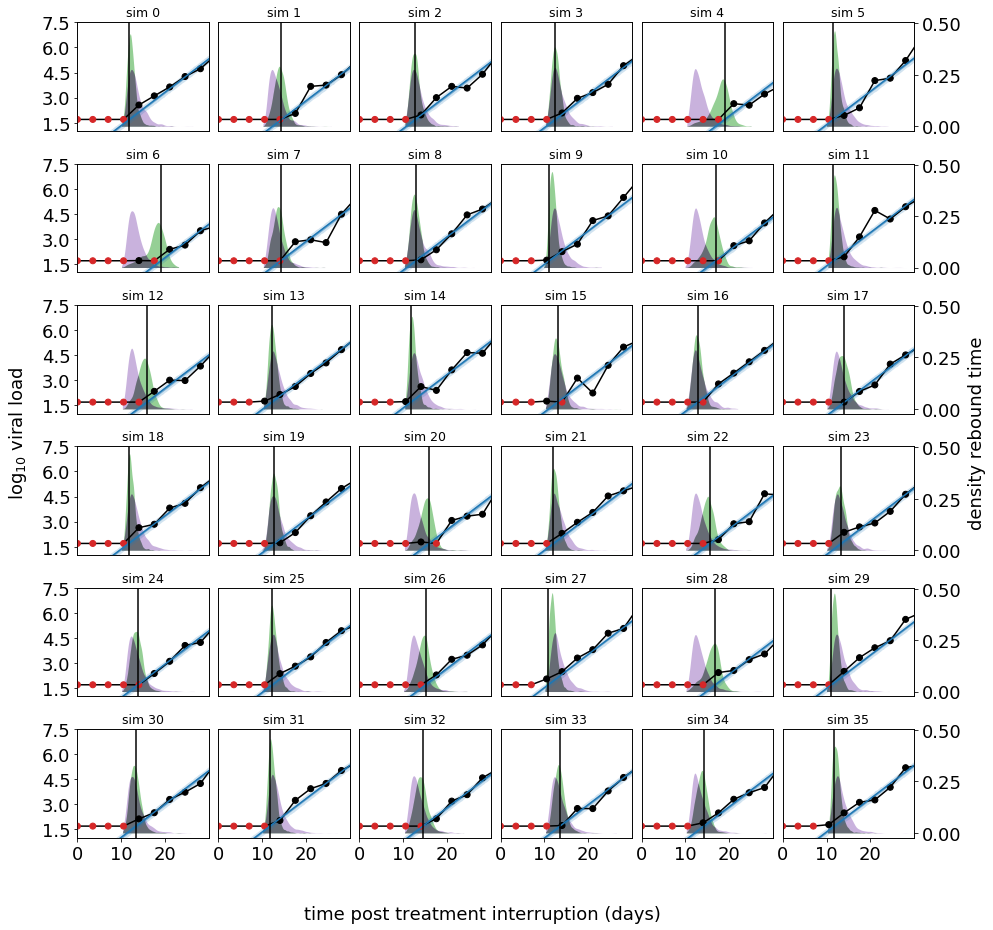

In [7]:
## Plot the fits and the data

cols = 6
rows = len(IDs) // cols + (0 if len(IDs) % cols == 0 else 1)
fig = plt.figure(figsize=(15, 15))
gs = GridSpec(rows, cols)
gs.update(wspace=0.07, hspace=0.3)

bxs = []

for i, ID in enumerate(IDs):
    col = i % cols
    row = i // cols
    ax = fig.add_subplot(gs[row, col])
    ## plot the data used for fitting on foreground
    ts, VLs, CCs = util.unzip(sim_data_dict[ID])
    logVLs = np.log(VLs) / np.log(10)
    ax.plot(ts, logVLs, zorder=1, color='k')
    colors = ['k' if CC == defn.uncensored_code else 'tab:red' for CC in CCs]
    ax.scatter(ts, logVLs, color=colors, zorder=2)
    ax.set_title(f"sim {ID}", fontsize='x-small')
    ## add model predictions
    logVLhats = chain["logVLhat"][:, i, :].T / np.log(10)
    meanLogVLhats = [np.mean(xs) for xs in logVLhats]
    qsLogVLhats = [np.percentile(xs, [25, 75]) for xs in logVLhats]
    logVLsims = chain["logVLsim"][:, i, :].T / np.log(10)
    qsLogVLsims = [np.percentile(xs, [25, 75]) for xs in logVLsims]
    tts = np.linspace(0, np.max(ts), NumSimTimePts, endpoint=True)
    ax.plot(tts, meanLogVLhats, color='tab:blue')
    ax.fill_between(tts, [q[0] for q in qsLogVLhats], [q[1] for q in qsLogVLhats], 
                    color='tab:blue', alpha=0.5, linewidth=0)
    ax.fill_between(tts, [q[0] for q in qsLogVLsims], [q[1] for q in qsLogVLsims], 
                    color='tab:blue', alpha=0.2, linewidth=0)
    ax.set_ylim(1, 7.5)
    ax.set_yticks(np.linspace(1.5, 7.5, 5))
    ## plot rebound times
    reboundTime = chain["reboundTime"][:,i]
    meanReboundTime = np.mean(reboundTime)
    qsReboundTime = np.percentile(reboundTime, [25, 75])
    ax.axvline(x=meanReboundTime, color='k')
    bx = ax.twinx()
    ## make a histogram from simulated rebound times 
    simtaus = [x for x in chain["timeToReboundsim"][:,i] if not np.isnan(x)]
    kde = sts.gaussian_kde(simtaus)
    xs = np.linspace(np.min(simtaus), np.max(simtaus), 500)
    ys = kde(xs)
    bx.fill_between(xs, ys, color='tab:purple', alpha=0.5, linewidth=0, zorder=2)
    bx.set_yticks(np.linspace(0.0, 0.5, 3))
    ## make a histogram from simulated rebound times conditioned on the first reactivation
    simtaus = [x for x in chain["timeToReboundsimCndlFstReactiv"][:,i] if not np.isnan(x)]
    kde = sts.gaussian_kde(simtaus)
    ys_cndl = kde(xs) ## use same xs as above
    bx.fill_between(xs, ys_cndl, color='tab:green', alpha=0.5, linewidth=0, zorder=1)
    overlap = [min(y, y_cndl) for y, y_cndl in zip(ys, ys_cndl)]
    bx.fill_between(xs, overlap, color='k', alpha=0.3, linewidth=0, zorder=3)
    ## add bs to list to share y-scale
    bxs.append(bx)
    ## zoom in
    ax.set_xlim(0, 30)
    ax.set_xticks(range(0, 30, 10))
    ## remove repeated axes
    if col > 0:
        ax.get_yaxis().set_visible(False)
    if col < cols-1:
        bx.get_yaxis().set_visible(False)
    if row < rows-1:
        ax.get_xaxis().set_visible(False)
    ## move the distributions to the background (as twinx puts them in the foreground)
    ax.set_zorder(bx.get_zorder()+1) # put ax in front of bx
    ax.patch.set_visible(False) # hide the 'canvas' 

bxs[0].get_shared_y_axes().join(*bxs)
bxs[0].autoscale(axis='y')
    
fig.text(0.06, 0.5, "$\\log_{10}$ viral load", va='center', rotation=90)
fig.text(0.95, 0.5, "density rebound time", va='center', rotation=90)
fig.text(0.5, 0.05, "time post treatment interruption (days)", ha='center')

### Inspect estimates

Look at the estimate of $\lambda$ and $g$ (marginal densities) and the true values (the vertical lines below)

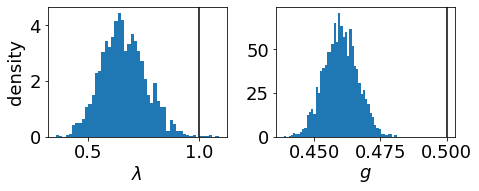

In [8]:
fig, (ax, bx) = plt.subplots(1, 2, figsize=(7,3))
ax.hist(chain["lambda"], 50, density=True)
ax.axvline(x=lam0, color='k')
ax.set_xlabel("$\lambda$")
ax.set_ylabel("density")

bx.hist(chain["r"], 50, density=True)
bx.axvline(x=g, color='k')
bx.set_xlabel("$g$")

fig.tight_layout()

### Systematic analysis of the bias with different estimation methods

We define a function `fit_stan_model` that does some of the work shown above for us.
We give the function a compled Stan model, a data set, the "true" values of $v_0$ and $\ell$,
and guesses for $\lambda$ and $g$. The function returns the result of the Stan run.

In [9]:
def fit_stan_model(sm, data_dict, v0, ell, lam_guess, r_guess, num_chains=4, iter=1000):
    ## prepare data for Stan
    IDs = sorted(list(data_dict.keys()))
    NumTimePts = [len(data_dict[ID]) for ID in IDs]
    zpadding = [[0 for _ in range(max(NumTimePts) - n)] for n in NumTimePts]
    cpadding = [[defn.missing_code for _ in range(max(NumTimePts) - n)] 
                for n in NumTimePts]
    
    TimePts = [[x[0] for x in data_dict[ID]] + pad 
               for ID, pad in zip(IDs, zpadding)]
    VirusLoad = [[x[1] for x in data_dict[ID]] + pad 
                 for ID, pad in zip(IDs, zpadding)]
    CensorCode = [[x[2] for x in data_dict[ID]] + pad 
                  for ID, pad in zip(IDs, cpadding)]
    
    PriorMeanSigma = 0.0
    PriorSdSigma = 0.5

    NumSimTimePts = 10 ## we don't really need any: save some RAM

    stan_data_dict = {
        "NumSubjects" : len(IDs),
        "NumTimePts" : NumTimePts,
        "TimePts" : TimePts,
        "NumSimTimePts" : NumSimTimePts,
        "VirusLoad" : VirusLoad,
        "CensorCode" : CensorCode,
        "DetectionLimit" : ell,
        "PriorMeanLogR" : 0.0,
        "PriorSdLogR" : 1.0,
        "MaxR" : 4.0,
        "PriorMeanSigma" : PriorMeanSigma,
        "PriorSdSigma" : PriorSdSigma,
        ## hyper parameters for the reactivation model
        "PriorMeanLogLambda" : 0.0,
        "PriorSdLogLambda" : 3.0,
        "LogVZero" : np.log(v0),
    }

    loglam_guess = np.log(lam_guess)
    logr_guess = np.log(r_guess)
    approx_rel_tau = stats.approx_rel_rebound_time(lam_guess, r_guess, v0, ell)
    ## give Stan initial guesses.
    init_dict = {
       "sigma" : PriorMeanSigma + PriorSdSigma,
       "logr" : logr_guess,
       ## initial values for the reavtivation model
       "loglambda" : np.log(lam_guess),
       "fstReactivTime" : [1/lam_guess for _ in IDs],
       "relativeReboundTime" : [approx_rel_tau for _ in IDs],
    }
    control_dict = {
        "adapt_delta" : 0.99,
        "max_treedepth" : 20
    }
    kwargs = {
        "data" : stan_data_dict,
        "init" : [init_dict for _ in range(num_chains)],
        "iter" : iter,
        "chains" : num_chains,
        "thin" : 1,
        "control" : control_dict,
        "refresh" : 1
    }
    ## initiation of the Stan model sometimes fails: return None in that case
    try:
        sam = sm.sampling(**kwargs)
        return sam
    except RuntimeError as e:
        return None

## 4. Sensitivity to intra-host variation in $G$.

Using different values of $\lambda$ and different standard deviations $\sigma_G$ of $G$,
we simulate data with the generalized multiple-reactivation model.
We then create a list of "tasks" that can be executed in parallel using the `fit_stan_model` function
defined above.

**The simulations take time when $\lambda$ is large**

In [11]:
num_sigmaGs = 5 ## 21

lam0s = np.logspace(np.log10(0.2), np.log10(5.0), 3, base=10)
sigmaGs = np.linspace(0, 0.2*g, num_sigmaGs)

num_sims = 20 ## 200
v0 = 0.1
ell = 50
g = 0.5
measurement_interval = 3.5
peak_VL = 1e6
sigma_VL = 0.3
num_chains = 1
iter = 1000
 
## make a list of tasks...
tasks = []

for lam in lam0s:
    for sigmaG in sigmaGs:
        print("creating task with lambda =", lam, "sigmaG =", sigmaG)
        if sigmaG == 0:
            ## use a fixed growth rate
            ggen = lambda: g
        else:
            ## use the propto distribution
            ggen = stats.gen_ggen_trunc_propto(sigmaG, g)
        ## simulate data
        sim_data_dict = {}
        for i in range(num_sims):
            ts, Vobs, Vtots, Ts, gs = \
                sims.simVGtimeseries(ell, ggen, v0, lam, measurement_interval, peak_VL, sigma_VL)
            VLs = [x[0] for x in Vobs]
            CCs = [x[1] for x in Vobs]
            sim_data_dict[i] = list(zip(ts, VLs, CCs))
        ## make a new task
        task = {
            "sm" : sm_Gsp_II,
            "sim_data_dict" : sim_data_dict,
            "v0" : v0,
            "ell" : ell,
            "lam0" : lam,
            "g" : g,
            "sigmaG" : sigmaG,
            "num_chains" : num_chains,
            "iter" : iter,
        }
        ## and add the task to the task list
        tasks.append(task)

print(f"about to do {len(tasks)} tasks")

creating task with lambda = 0.2 sigmaG = 0.0
creating task with lambda = 0.2 sigmaG = 0.025
creating task with lambda = 0.2 sigmaG = 0.05
creating task with lambda = 0.2 sigmaG = 0.075
creating task with lambda = 0.2 sigmaG = 0.1
creating task with lambda = 1.0 sigmaG = 0.0
creating task with lambda = 1.0 sigmaG = 0.025
creating task with lambda = 1.0 sigmaG = 0.05
creating task with lambda = 1.0 sigmaG = 0.075
creating task with lambda = 1.0 sigmaG = 0.1
creating task with lambda = 5.0 sigmaG = 0.0
creating task with lambda = 5.0 sigmaG = 0.025
creating task with lambda = 5.0 sigmaG = 0.05
creating task with lambda = 5.0 sigmaG = 0.075
creating task with lambda = 5.0 sigmaG = 0.1
about to do 15 tasks


Now use `multiprocessing.Pool.map` to execute the list of tasks

**This can take a lot of time!**

In [12]:
def fun(task):
    """
    Use the multiprocessing module to speed up the sensitivity
    analysis. We have to define a function that can be 
    "mapped" over the fits that we want to do with Pool.map.
    """
    sm = task["sm"]
    sim_data_dict = task["sim_data_dict"]
    v0 = task["v0"]
    ell = task["ell"]
    lam0 = task["lam0"]
    g = task["g"]
    sigmaG = task["sigmaG"]
    num_chains = task["num_chains"]
    iter = task["iter"]
    ## run the stan model
    sam = fit_stan_model(sm, sim_data_dict, v0, ell, lam0, g, 
                         num_chains=num_chains, iter=iter)
    if sam is not None:
        chain = sam.extract(permuted=True, pars=["lambda", "r"])
    else:
        chain = {}
    result = {
        "chain" : chain,
        "v0" : v0,
        "lam0" : lam0,
        "sigmaG" : sigmaG,
    }
    return result

## Execute all the fitting jobs

with Pool(processes=cpu_count()-2) as pool:
    results_randomG = pool.map(fun, tasks)

## 5. Investigate the effect of a misspecified $v_0$

The procedure is as the one above, We...

1. So simulations with different parameters and create a list of fitting tasks  
2. We then use `multiprocessing.Pool.map` to execute these tasks

Again, both these operations **can take some time**

In [13]:
num_v0s = 5 ## 21

## use same lam0s as in sigmaG analysis
g = 0.5
ggen = lambda: g ## Dirac-delta distribution for G
num_sims = 20 ## 200
iter = 1000
num_chains = 1
v0_true = 0.1 ## the ground-truth value
ell = 50
measurement_interval = 3.5
peak_VL = 1e6
sigma_VL = 0.3

v0s = np.logspace(np.log10(0.02), np.log10(0.5), num_v0s, base=10)

## create task list    
tasks = []

for lam0 in lam0s:
    for v0 in v0s:
        print("creating task with v0 =", v0, "lam0 =", lam0)
        ## simulate data
        sim_data_dict = {}
        for i in range(num_sims):
            ## simulate with the "true" v0: v0_true
            ts, Vobs, Vtots, Ts, gs = \
                sims.simVGtimeseries(ell, ggen, v0_true, lam0, 
                                     measurement_interval, peak_VL, sigma_VL)
            VLs = [x[0] for x in Vobs]
            CCs = [x[1] for x in Vobs]
            sim_data_dict[i] = list(zip(ts, VLs, CCs))
        task = {
            "sm" : sm_Gsp_II,
            "sim_data_dict" : sim_data_dict,
            "v0" : v0,
            "ell" : ell,
            "lam0" : lam0,
            "g" : g,
            "num_chains" : num_chains,
            "iter" : iter,
        }
        tasks.append(task)
        
print(f"about to do {len(tasks)} tasks")

creating task with v0 = 0.02 lam0 = 0.2
creating task with v0 = 0.04472135955 lam0 = 0.2
creating task with v0 = 0.1 lam0 = 0.2
creating task with v0 = 0.22360679775 lam0 = 0.2
creating task with v0 = 0.5 lam0 = 0.2
creating task with v0 = 0.02 lam0 = 1.0
creating task with v0 = 0.04472135955 lam0 = 1.0
creating task with v0 = 0.1 lam0 = 1.0
creating task with v0 = 0.22360679775 lam0 = 1.0
creating task with v0 = 0.5 lam0 = 1.0
creating task with v0 = 0.02 lam0 = 5.0
creating task with v0 = 0.04472135955 lam0 = 5.0
creating task with v0 = 0.1 lam0 = 5.0
creating task with v0 = 0.22360679775 lam0 = 5.0
creating task with v0 = 0.5 lam0 = 5.0
about to do 15 tasks


In [14]:
def fun(task):
    """
    Use the multiprocessing module to speed up the sensitivity
    analysis. We have to define a function that can be 
    "mapped" over the fits that we want to do with Pool.map.
    """
    ## extract info from the task
    sm = task["sm"]
    sim_data_dict = task["sim_data_dict"]
    v0 = task["v0"]
    ell = task["ell"]
    lam0 = task["lam0"]
    g = task["g"]
    num_chains = task["num_chains"]
    iter = task["iter"]
    ## run the stan model. Use the misspecified v0 instead of v0_true
    sam = fit_stan_model(sm, sim_data_dict, v0, ell, lam0, 
                         g, num_chains=num_chains, iter=iter)
    chain = sam.extract(permuted=True, pars=["lambda", "r"])
    result = {
        "chain" : chain,
        "v0" : v0,
        "lam0" : lam0,
    }
    return result    

with Pool(processes=cpu_count()-2) as pool:
    results_misspec_v0 = pool.map(fun, tasks)

## 6. Create Figure 5

collect the results for the two sensitivity analyses and combine them in a single figure.

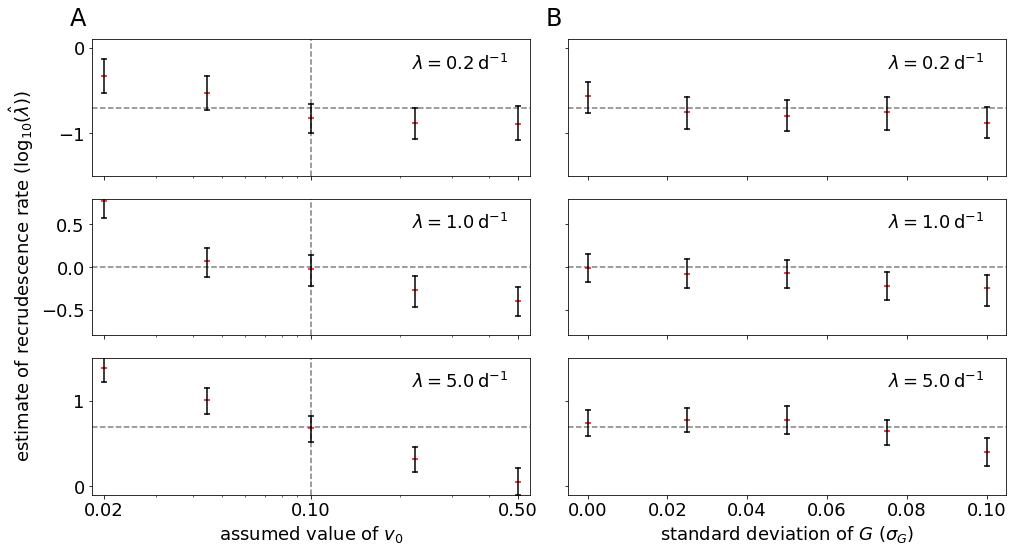

In [15]:
fig, axs = plt.subplots(len(lam0s), 2, figsize=(14, 8), sharex='col', sharey='row')

dy = np.power(10.0, np.array([-0.8, 0.8]))

## put predictions for lambda from the v0 misspecification analysis in the left panels

for result in results_misspec_v0:
    chain = result["chain"]
    lam = result["lam0"]
    v0 = result["v0"]
    m = list(lam0s).index(lam)
    ax = axs[m, 0]
    if "lambda" in chain.keys():
        lam_estimate = [np.log10(chain["lambda"])]
        plots.simple_boxplot(ax, [v0], lam_estimate, p=95, zorder=2, color='k')
    else:
        print("MCMC failed for", result)


for lam0, ax in zip(lam0s, axs[:,0]):
    ax.set_xscale('log')
    ax.set_ylim(np.log10(lam0*dy[0]), np.log10(lam0*dy[1]))
    ax.axhline(y=np.log10(lam0), color='k', alpha=0.5, linestyle='--', zorder=1)
    ax.text(0.95, 0.9, f"$\\lambda = {lam0:0.1f}\\, \\mathrm{{d}}^{{-1}}$", 
            transform=ax.transAxes, ha='right', va='top')
    ax.axvline(x=v0_true, color='k', alpha=0.5, linestyle='--', zorder=1)

axs[-1,0].set_xlabel("assumed value of $v_0$")

mpad = 1.1
axs[-1,0].set_xlim(np.min(v0s)/mpad, np.max(v0s)*mpad)
axs[-1,0].set_xticks([0.02, 0.1, 0.5])
axs[-1,0].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

## put predictions for lambda from the randomG analysis in the right panels

for result in results_randomG:
    chain = result["chain"]
    lam = result["lam0"]
    sigmaG = result["sigmaG"]
    m = list(lam0s).index(lam)
    ax = axs[m, 1]
    if "lambda" in chain.keys():
        lam_estimate = [np.log10(chain["lambda"])]
        plots.simple_boxplot(ax, [sigmaG], lam_estimate, p=95, zorder=2)
    else:
        print("MCMC failed for", result)


for lam0, ax in zip(lam0s, axs[:,1]):
    #ax.set_yscale('log')
    ax.axhline(y=np.log10(lam0), color='k', alpha=0.5, linestyle='--', zorder=1)
    ax.text(0.95, 0.9, f"$\\lambda = {lam0:0.1f}\\, \\mathrm{{d}}^{{-1}}$", 
            transform=ax.transAxes, ha='right', va='top')

apad = 0.005
axs[-1,1].set_xlim(np.min(sigmaGs)-apad, np.max(sigmaGs)+apad)
    
axs[-1,1].set_xlabel("standard deviation of $G$ ($\\sigma_G$)")    

fig.text(0, 0.5, "estimate of recrudescence rate ($\\log_{10}(\\hat{\\lambda})$)", 
         rotation=90, ha='center', va='center')

axs[0,0].text(-0.05, 1.1, "A", fontsize=24, transform=axs[0,0].transAxes)
axs[0,1].text(-0.05, 1.1, "B", fontsize=24, transform=axs[0,1].transAxes)

fig.tight_layout()

#fig.savefig("../Figure5.pdf", bbox_inches="tight")